# Carga datos places desde el bucket de AWS

In [1]:
"""   Librerías   """
import pandas as pd # Manipulación y EDA
import numpy as np # Manipulación y EDA
import matplotlib.pyplot as plt # Gráficos
import seaborn as sns # Gráficos
from dataAccess import aws_df_from_S3_csv # AWS

In [416]:
dataset = aws_df_from_S3_csv("Arnau/places_clean.csv")
dataset = dataset.rename(columns = {'Unnamed: 0':'id'})
dataset.head()

,id,place_id,name,business_status,rating,user_ratings_total,price_level,scope,types,find_type,lat,lon
0,0,ChIJFxKKG7wnQg0RNYE_E60EZ7g,La Madreña Santa Lucrecia,OPERATIONAL,3.8,1348,2,GOOGLE,"['restaurant', 'food', 'point_of_interest', 'e...",restaurant,40.386727,-3.718799
1,1,ChIJo3OI7JYnQg0RGV2mWtE-9v8,Restaurante World,OPERATIONAL,4.0,220,1,GOOGLE,"['restaurant', 'food', 'point_of_interest', 'e...",restaurant,40.385361,-3.726651
2,2,ChIJwXyYMZEnQg0Rb9hEHqaxtO8,Bar Alfonsillo,OPERATIONAL,4.5,402,1,GOOGLE,"['cafe', 'bar', 'restaurant', 'food', 'point_o...",restaurant,40.384738,-3.728618
3,3,ChIJbYvKyL0nQg0R981bqgVos40,Mesón A Casiña,OPERATIONAL,4.4,333,1,GOOGLE,"['restaurant', 'cafe', 'bar', 'food', 'point_o...",restaurant,40.385918,-3.721233
4,4,ChIJvz9205AnQg0RC21REfqPWeU,Doner Kebab Lima,OPERATIONAL,3.3,13,-1,GOOGLE,"['meal_delivery', 'restaurant', 'food', 'point...",restaurant,40.383741,-3.728431


# EDA

In [417]:
# Número de registros que contiene el dataset
print("El dataset contiene un total de {} establecimientos.\n".format(len(dataset)))

El dataset contiene un total de 10614 establecimientos.



In [418]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10614 entries, 0 to 10613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10614 non-null  int64  
 1   place_id            10614 non-null  object 
 2   name                10614 non-null  object 
 3   business_status     10614 non-null  object 
 4   rating              10614 non-null  float64
 5   user_ratings_total  10614 non-null  int64  
 6   price_level         10614 non-null  int64  
 7   scope               10614 non-null  object 
 8   types               10614 non-null  object 
 9   find_type           10614 non-null  object 
 10  lat                 10614 non-null  float64
 11  lon                 10614 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 995.2+ KB


In [419]:
# Añadimos una columna que marque el dato missing en price_level
dataset["price_level_missing"] = dataset['price_level'].apply(lambda x: 1 if x == -1 else 0)
dataset["price_level_missing"].value_counts()

0    6087
1    4527
Name: price_level_missing, dtype: int64

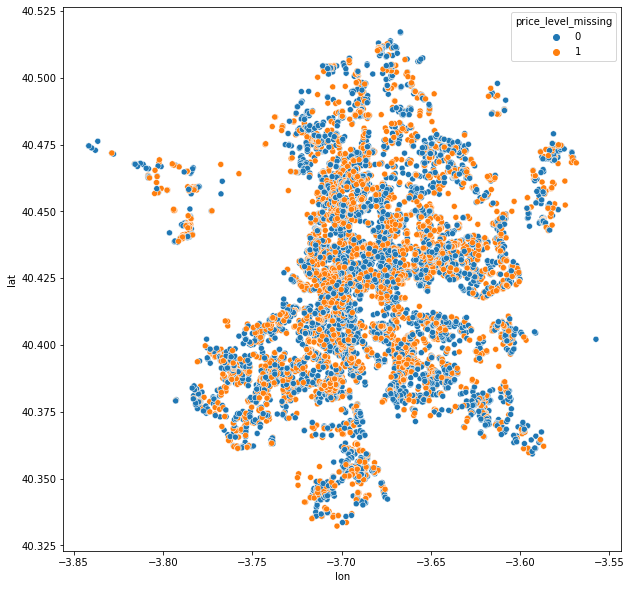

In [420]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='lon', y='lat', data=dataset, hue='price_level_missing')
plt.show()

La distribución de los datos missing es similar a la de los datos existentes.

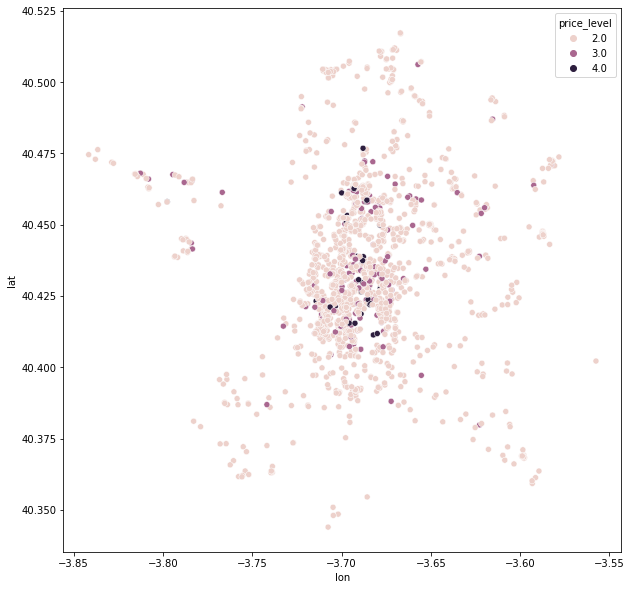

In [479]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='lon', y='lat', data=dataset[dataset["price_level"] > 1], hue='price_level')
plt.show()

Los establecimientos con price_level 1,2 y 3 están distribuidos por todo el mapa. Los de price_level 4 solo por la zona central.

# Imputación NA

In [422]:
# Convertimos los -1 a NA
dataset["price_level"] = dataset["price_level"].replace(-1, np.nan)
dataset.price_level.value_counts()

1.0    4490
2.0    1410
3.0     157
4.0      30
Name: price_level, dtype: int64

In [423]:
for i in list(dataset.price_level.value_counts()):
    print(np.round(i/dataset.price_level.notnull().sum()*100,2),'%')

73.76 %
23.16 %
2.58 %
0.49 %


In [433]:
# Seleccionamos las variables numéricas
dataset_num = dataset[['id','rating', 'user_ratings_total','price_level','lat', 'lon','price_level_missing']]
dataset_num.head()

,id,rating,user_ratings_total,price_level,lat,lon,price_level_missing
0,0,3.8,1348,2.0,40.386727,-3.718799,0
1,1,4.0,220,1.0,40.385361,-3.726651,0
2,2,4.5,402,1.0,40.384738,-3.728618,0
3,3,4.4,333,1.0,40.385918,-3.721233,0
4,4,3.3,13,NaN,40.383741,-3.728431,1


## KNN Imputer - *Mejorado más abajo con selección manual*

In [434]:
from sklearn.impute import KNNImputer

In [435]:
imputer = KNNImputer(n_neighbors=5, weights="distance") # distance
knn_result = pd.DataFrame(np.ceil(imputer.fit_transform(dataset_num)),columns = dataset_num.columns) # ¡¡ np.ceil !!

In [436]:
knn_result.price_level.value_counts()

1.0    7459
2.0    2918
3.0     207
4.0      30
Name: price_level, dtype: int64

In [437]:
for i in list(knn_result.price_level.value_counts()):
    print(np.round(i/len(knn_result)*100,2),'%')

70.28 %
27.49 %
1.95 %
0.28 %


## Iterative Imputer - *descartada por los resultados*

In [438]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [439]:
imputer = IterativeImputer()
it_result = pd.DataFrame(np.round(imputer.fit_transform(dataset_num)),columns = dataset_num.columns)

In [440]:
it_result.price_level.value_counts()

1.0    8960
2.0    1460
3.0     160
4.0      32
6.0       1
7.0       1
Name: price_level, dtype: int64

In [441]:
for i in list(it_result.price_level.value_counts()):
    print(np.round(i/len(it_result)*100,2),'%')

84.42 %
13.76 %
1.51 %
0.3 %
0.01 %
0.01 %


## Imputación KNN con selección manual

Tenemos en cuenta: los establecimientos con price_level = 3 tienen como mínimo 4 reviews y los de price_level = 4 tienen un mínimo de 20. Ambos tienen un rating siempre superior a 2.

In [442]:
def percent(df):
    """ Función para visualizar proporciones de la variable price_level """
    print(df.price_level.value_counts())
    for i in list(df.price_level.value_counts()):
        print(np.round(i/df.price_level.notnull().sum()*100,2),'%')

In [443]:
q1 = dataset_num[(dataset_num["user_ratings_total"] < 4)]
percent(q1)

1.0    14
2.0     1
Name: price_level, dtype: int64
93.33 %
6.67 %


In [444]:
imputer = KNNImputer(n_neighbors=3, weights="distance") # distance
knn_result_1 = pd.DataFrame(np.round(imputer.fit_transform(q1)),columns = q1.columns)
percent(knn_result_1)

1.0    786
2.0     19
Name: price_level, dtype: int64
97.64 %
2.36 %


In [445]:
q2 = dataset_num[(dataset_num["user_ratings_total"] >= 4) & (dataset_num["user_ratings_total"] <= 1000)]
percent(q2)

1.0    4145
2.0     939
3.0      98
4.0      27
Name: price_level, dtype: int64
79.57 %
18.03 %
1.88 %
0.52 %


In [446]:
imputer = KNNImputer(n_neighbors=3, weights="distance") # distance
knn_result_2 = pd.DataFrame(np.ceil(imputer.fit_transform(q2)),columns = q2.columns) # ¡¡ np.ceil !!
percent(knn_result_2)

1.0    6866
2.0    1824
3.0     153
4.0      31
Name: price_level, dtype: int64
77.37 %
20.55 %
1.72 %
0.35 %


In [447]:
q3 = dataset_num[(dataset_num["user_ratings_total"] > 1000)]
percent(q3)

2.0    470
1.0    331
3.0     59
4.0      3
Name: price_level, dtype: int64
54.46 %
38.35 %
6.84 %
0.35 %


In [448]:
imputer = KNNImputer(n_neighbors=3, weights="distance") # distance
knn_result_3 = pd.DataFrame(np.round(imputer.fit_transform(q3)),columns = q3.columns)
percent(knn_result_3)

2.0    510
1.0    363
3.0     59
4.0      3
Name: price_level, dtype: int64
54.55 %
38.82 %
6.31 %
0.32 %


In [449]:
union = pd.concat([knn_result_1,knn_result_2,knn_result_3])
percent(union)

1.0    8015
2.0    2353
3.0     212
4.0      34
Name: price_level, dtype: int64
75.51 %
22.17 %
2.0 %
0.32 %


In [459]:
merge = dataset.merge(union[["id","price_level"]], how='left', on='id')

In [471]:
merge["price_level"] = merge["price_level_y"]
data_imputed = merge.drop(['id','price_level_x','price_level_y'], axis = 1)

In [472]:
data_imputed

,place_id,name,business_status,rating,user_ratings_total,scope,types,find_type,lat,lon,price_level_missing,price_level
0,ChIJFxKKG7wnQg0RNYE_E60EZ7g,La Madreña Santa Lucrecia,OPERATIONAL,3.8,1348,GOOGLE,"['restaurant', 'food', 'point_of_interest', 'e...",restaurant,40.386727,-3.718799,0,2.0
1,ChIJo3OI7JYnQg0RGV2mWtE-9v8,Restaurante World,OPERATIONAL,4.0,220,GOOGLE,"['restaurant', 'food', 'point_of_interest', 'e...",restaurant,40.385361,-3.726651,0,1.0
2,ChIJwXyYMZEnQg0Rb9hEHqaxtO8,Bar Alfonsillo,OPERATIONAL,4.5,402,GOOGLE,"['cafe', 'bar', 'restaurant', 'food', 'point_o...",restaurant,40.384738,-3.728618,0,1.0
3,ChIJbYvKyL0nQg0R981bqgVos40,Mesón A Casiña,OPERATIONAL,4.4,333,GOOGLE,"['restaurant', 'cafe', 'bar', 'food', 'point_o...",restaurant,40.385918,-3.721233,0,1.0
4,ChIJvz9205AnQg0RC21REfqPWeU,Doner Kebab Lima,OPERATIONAL,3.3,13,GOOGLE,"['meal_delivery', 'restaurant', 'food', 'point...",restaurant,40.383741,-3.728431,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10609,ChIJNbp6T_0oQg0Ri9OPOSBECSY,BANLOOclubbing,OPERATIONAL,3.0,276,GOOGLE,"['night_club', 'point_of_interest', 'establish...",night_club,40.453253,-3.693350,1,1.0
10610,ChIJI3Wk6B4pQg0RFac9nhaqqSE,Marmara,OPERATIONAL,3.5,22,GOOGLE,"['night_club', 'point_of_interest', 'establish...",night_club,40.458392,-3.685958,1,3.0
10611,ChIJgQbTRe0vQg0RZ0pyZ_by3rM,Pub Excalibur,OPERATIONAL,3.7,26,GOOGLE,"['night_club', 'point_of_interest', 'establish...",night_club,40.427210,-3.600738,1,4.0
10612,ChIJT9uIKp0oQg0RHAa2ajbH7aQ,The Ritz Garden,OPERATIONAL,4.3,33,GOOGLE,"['night_club', 'cafe', 'bar', 'restaurant', 'f...",night_club,40.415407,-3.692476,0,4.0


In [473]:
data_imputed.to_csv("places_imputed.csv")

In [482]:
data_dropna = dataset[dataset["price_level_missing"] == 0]
data_dropna = data_dropna.drop(['id','price_level_missing'], axis = 1)

In [484]:
data_dropna.to_csv("places_dropna.csv")

# Subir los datos a S3

In [485]:
# El fichero a subir tiene que estar guardado en local
aws_subir_archivo_s3("data2gether-playground","places_dropna.csv","Arnau") # Si funciona devuelve true

True